In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = 'data/covid/post_covid_study.csv'
df = pd.read_csv(file_path)
df.loc[
    (df['covid_status'].isin(['positive', 'suspected'])) & 
    ((df['covid'].isna()) | (df['covid']==False)), 
    'covid'
] = True
df.drop('covid_status', axis=1, inplace=True)


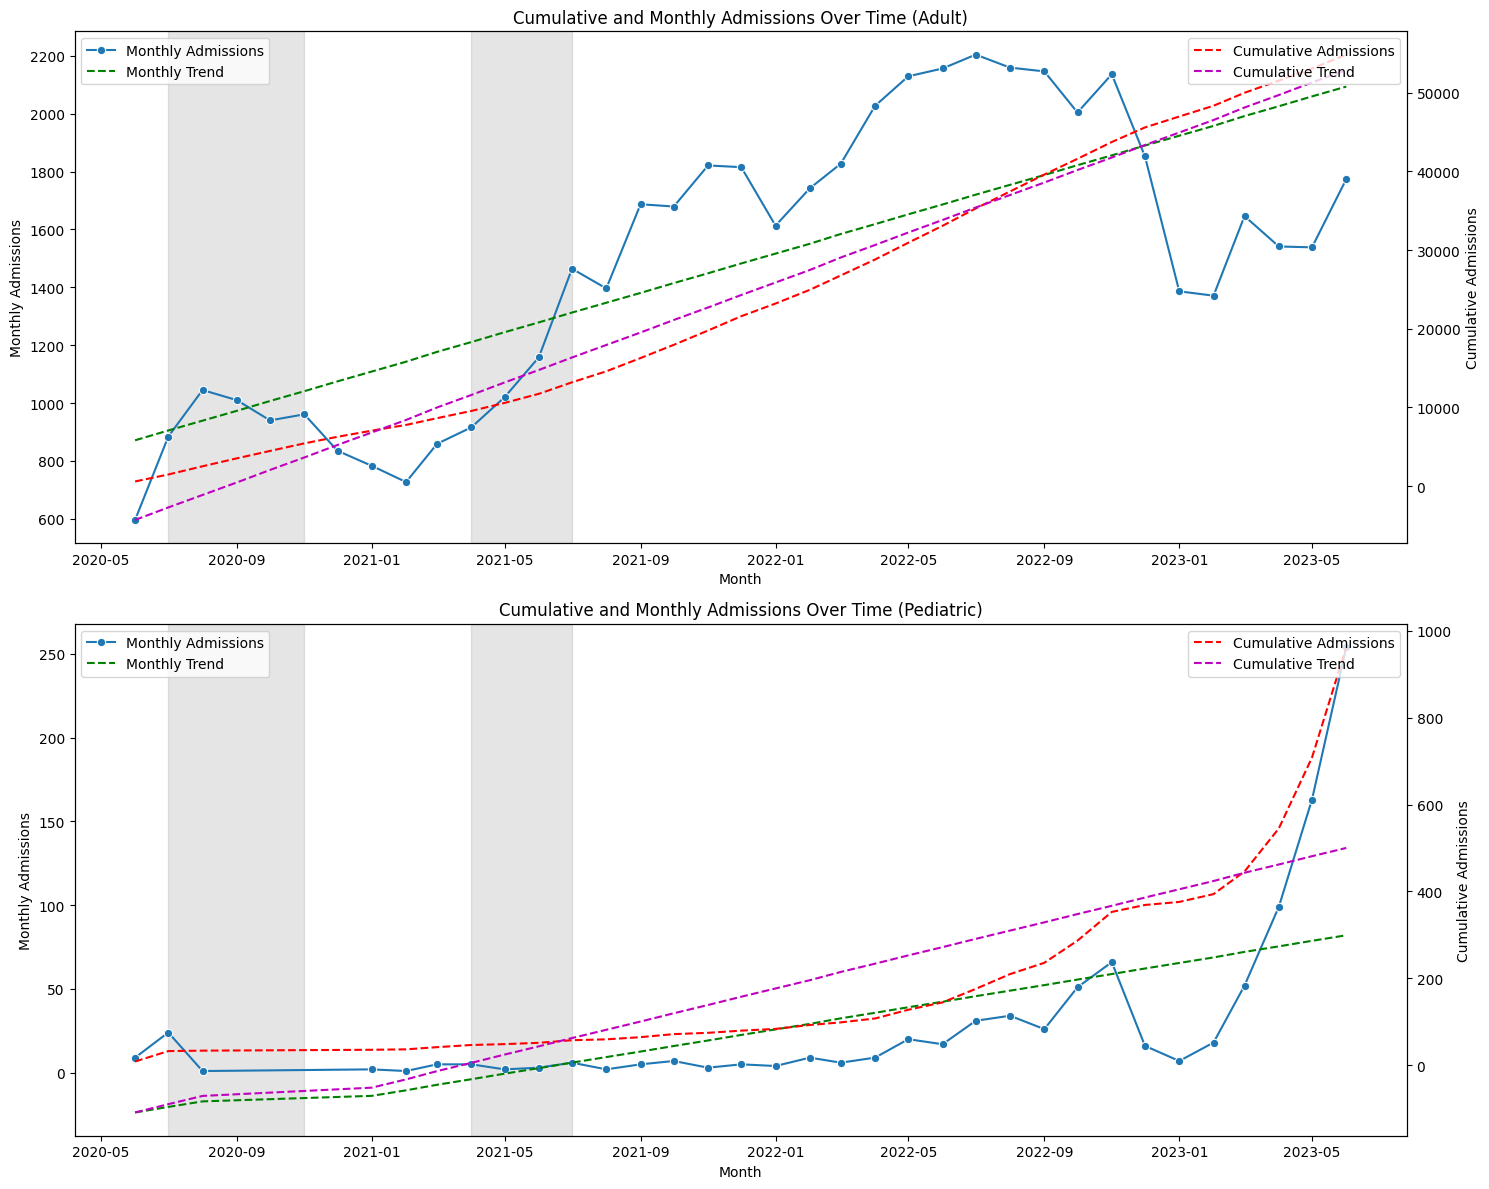

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
import numpy as np

# Shading regions for COVID-19 waves
covid_waves = [('2020-07-01', '2020-11-01'), ('2021-04-01', '2021-07-01')]

# Function to add shaded regions
def add_covid_shades(ax):
    for start, end in covid_waves:
        ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), color='gray', alpha=0.2, label='COVID-19 Wave')

# Preprocess the data
# Convert the 'month' column to datetime format
df['month'] = pd.to_datetime(df['month'])

# Sort the data by month
df = df.sort_values('month')

# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# List to store file paths for saving the plots
plot_file_paths = []

# Function to plot the data
def plot_data(ax, data, title):
    # Group data by month
    monthly_admissions = data.groupby('month').size()
    cumulative_admissions = monthly_admissions.cumsum()
    
    # Plotting
    ax1 = ax
    ax2 = ax.twinx()
    
    sns.lineplot(x=monthly_admissions.index, y=monthly_admissions.values, ax=ax1, label='Monthly Admissions', marker="o")
    sns.lineplot(x=cumulative_admissions.index, y=cumulative_admissions.values, ax=ax2, label='Cumulative Admissions', color='r', linestyle='--')
    
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Monthly Admissions')
    ax2.set_ylabel('Cumulative Admissions')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.set_title(title)
    
    ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    ax2.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    
    # Adding trendline for monthly admissions
    x = np.array(range(len(monthly_admissions)))
    y = monthly_admissions.values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax1.plot(monthly_admissions.index, p(x), "g--", label="Monthly Trend")
    
    # Adding trendline for cumulative admissions
    x = np.array(range(len(cumulative_admissions)))
    y = cumulative_admissions.values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax2.plot(cumulative_admissions.index, p(x), "m--", label="Cumulative Trend")
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Plot for adult
plot_data(axes[0], df[df['age_group'] == 'adult'], 'Cumulative and Monthly Admissions Over Time (Adult)')

# Plot for pediatric
plot_data(axes[1], df[df['age_group'] == 'pediatric'], 'Cumulative and Monthly Admissions Over Time (Pediatric)')

add_covid_shades(axes[0])
add_covid_shades(axes[1])

# Save the plots
plot_file_path = 'data/covid/admissions_over_time_plots.png'
plt.savefig(plot_file_path)
plot_file_paths.append(plot_file_path)

plt.tight_layout()
plt.show()


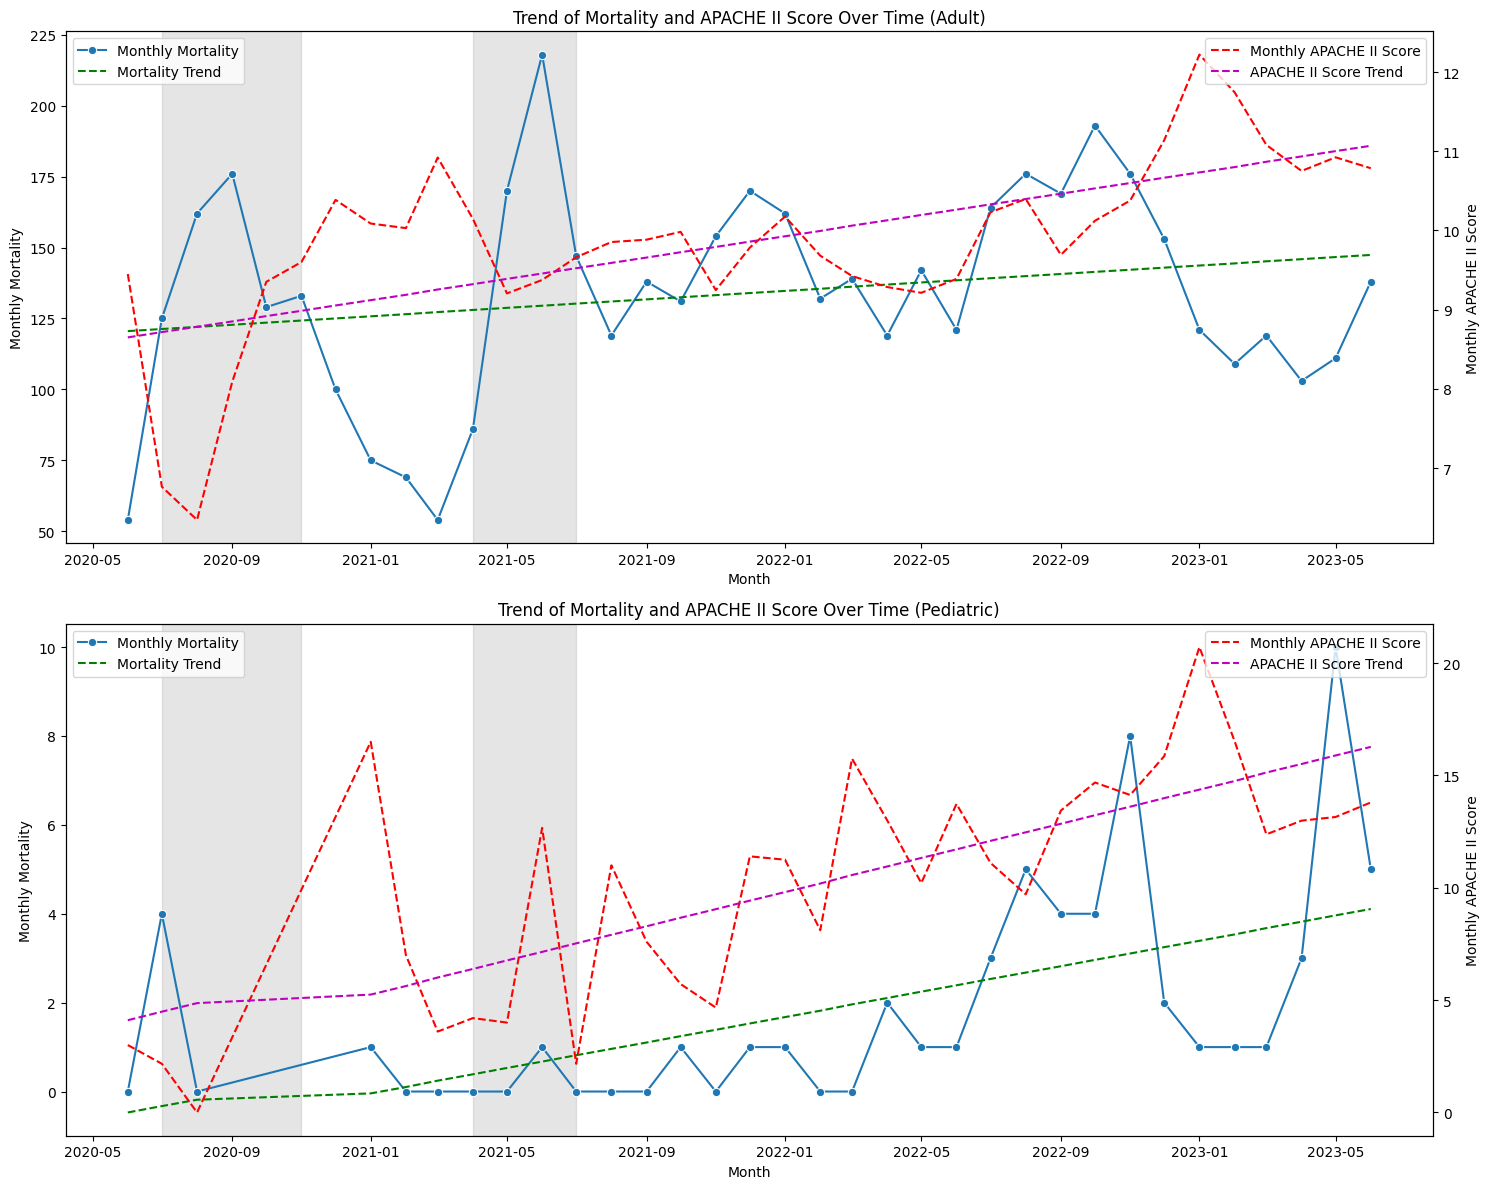

In [3]:
# Filter out rows where discharge_disposition or apache_score is NaN
df_adult = df[(df['age_group'] == 'adult') & df['discharge_disposition'].notna() & df['apache_score'].notna()]
df_pediatric = df[(df['age_group'] == 'pediatric') & df['discharge_disposition'].notna() & df['apache_score'].notna()]

# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Function to plot mortality and APACHE II score
def plot_mortality_and_apache(ax, data, title):
    # Group data by month
    monthly_mortality = data.groupby('month')['discharge_disposition'].apply(lambda x: (x == 'Death').sum())
    monthly_apache = data.groupby('month')['apache_score'].mean()
    
    # Plotting
    ax1 = ax
    ax2 = ax.twinx()
    
    sns.lineplot(x=monthly_mortality.index, y=monthly_mortality.values, ax=ax1, label='Monthly Mortality', marker="o")
    sns.lineplot(x=monthly_apache.index, y=monthly_apache.values, ax=ax2, label='Monthly APACHE II Score', color='r', linestyle='--')
    
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Monthly Mortality')
    ax2.set_ylabel('Monthly APACHE II Score')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.set_title(title)
    
    ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    ax2.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    
    # Adding trendline for monthly mortality
    x = np.array(range(len(monthly_mortality)))
    y = monthly_mortality.values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax1.plot(monthly_mortality.index, p(x), "g--", label="Mortality Trend")
    
    # Adding trendline for monthly APACHE II score
    x = np.array(range(len(monthly_apache)))
    y = monthly_apache.values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax2.plot(monthly_apache.index, p(x), "m--", label="APACHE II Score Trend")
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Plot for adult
plot_mortality_and_apache(axes[0], df_adult, 'Trend of Mortality and APACHE II Score Over Time (Adult)')

# Plot for pediatric
plot_mortality_and_apache(axes[1], df_pediatric, 'Trend of Mortality and APACHE II Score Over Time (Pediatric)')

add_covid_shades(axes[0])
add_covid_shades(axes[1])

# Save the plots
plot_file_path_mortality = 'data/covid/mortality_and_apache_over_time_plots.png'
plt.savefig(plot_file_path_mortality)
plot_file_paths.append(plot_file_path_mortality)

plt.tight_layout()
plt.show()

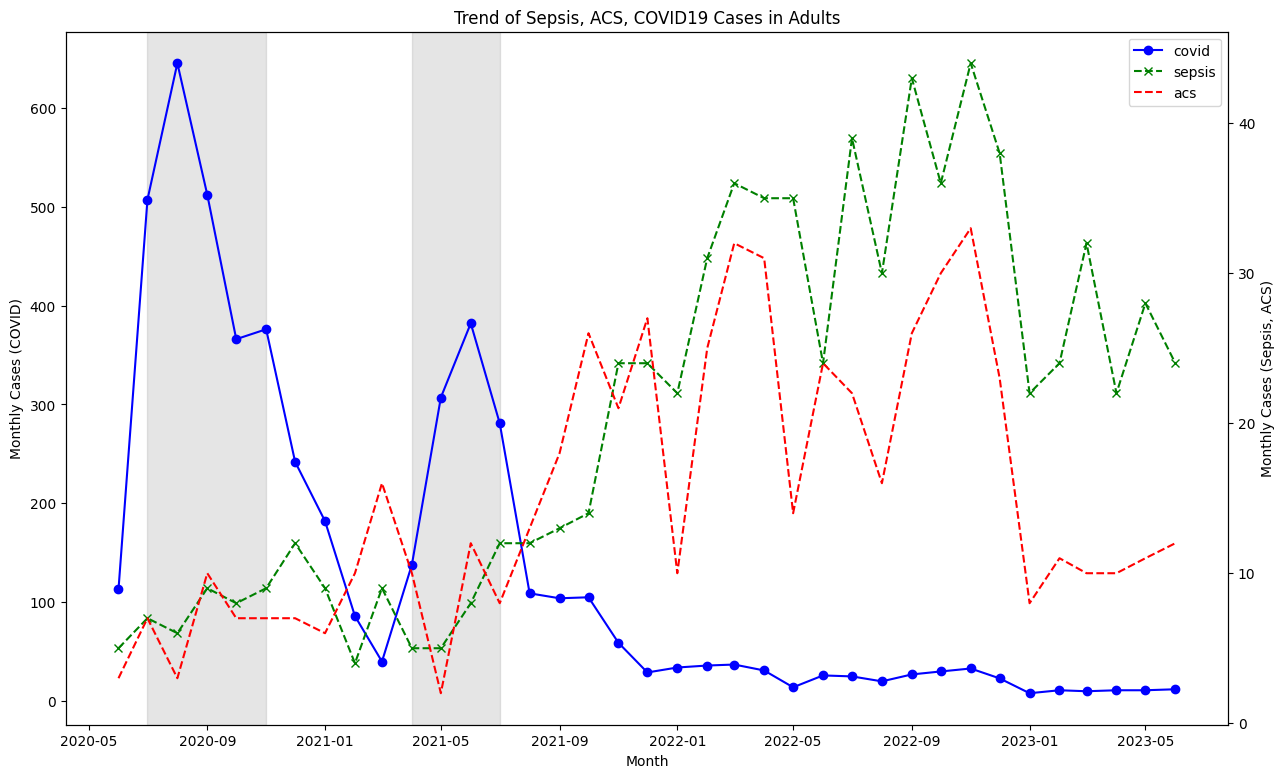

In [6]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

df_adult_metrics = df[(df['age_group'] == 'adult') & df[['sepsis', 'acs', 'covid']].notna().any(axis=1)]

def plot_adult_metrics(ax, data, title):
    # Group data by month
    monthly_metrics = data.groupby('month')[['sepsis', 'acs', 'covid']].sum()
    
    # Plotting covid on the left axis using Matplotlib
    ax.plot(monthly_metrics.index, monthly_metrics['covid'], label='covid', marker='o', color='blue')
    
    # Create a secondary Y-axis for sepsis and acs
    ax2 = ax.twinx()
    
    # Plot sepsis using Matplotlib
    ax2.plot(monthly_metrics.index, monthly_metrics['sepsis'], label='sepsis', linestyle='--', marker='x', color='green')
    
    # Plot acs using Matplotlib
    ax2.plot(monthly_metrics.index, monthly_metrics['acs'], label='acs', linestyle='--', color='red')
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Monthly Cases (COVID)')
    ax2.set_ylabel('Monthly Cases (Sepsis, ACS)')
    ax.set_title(title)
    
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    
    # Handling legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    add_covid_shades(ax)

fig1, ax1 = plt.subplots(figsize=(15, 9))
plot_adult_metrics(ax1, df_adult_metrics, 'Trend of Sepsis, ACS, COVID19 Cases in Adults')
plot_file_path_adult_metrics = 'data/covid/adult_metrics_with_covid_waves.png'
fig1.savefig(plot_file_path_adult_metrics)
plt.show()


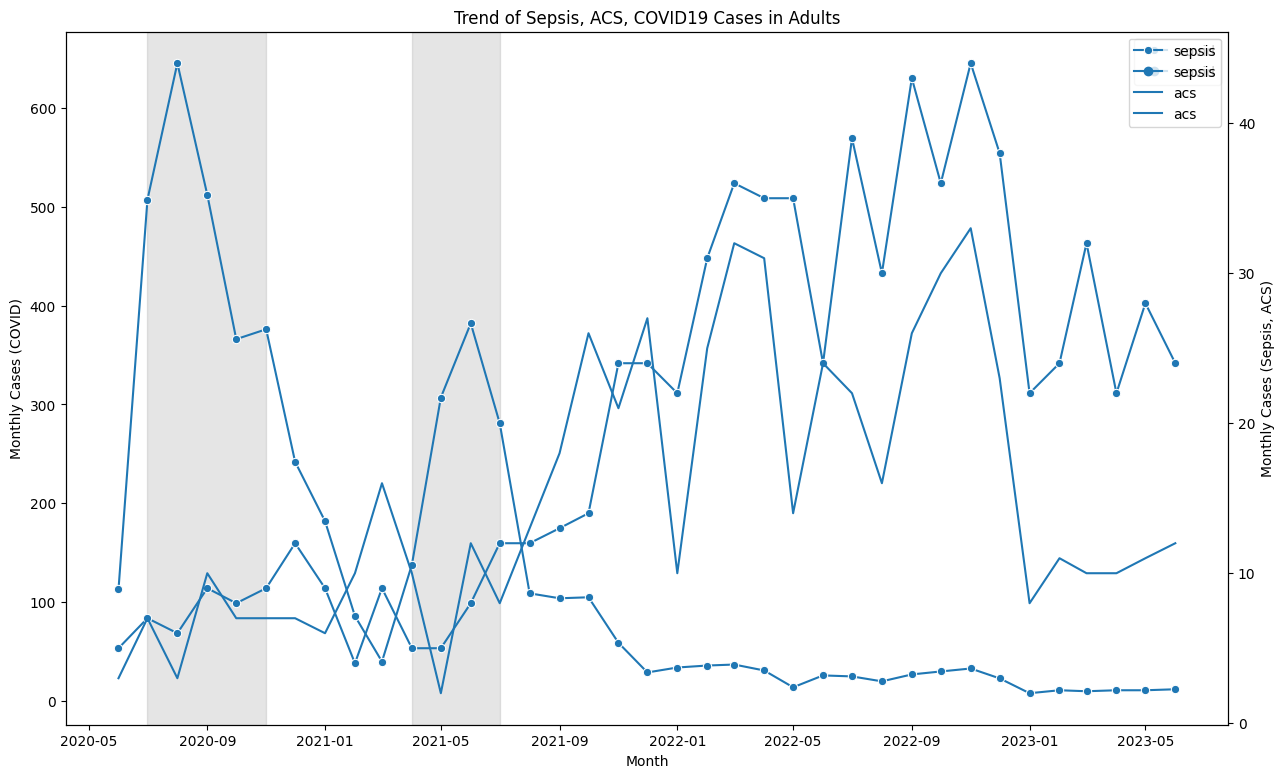

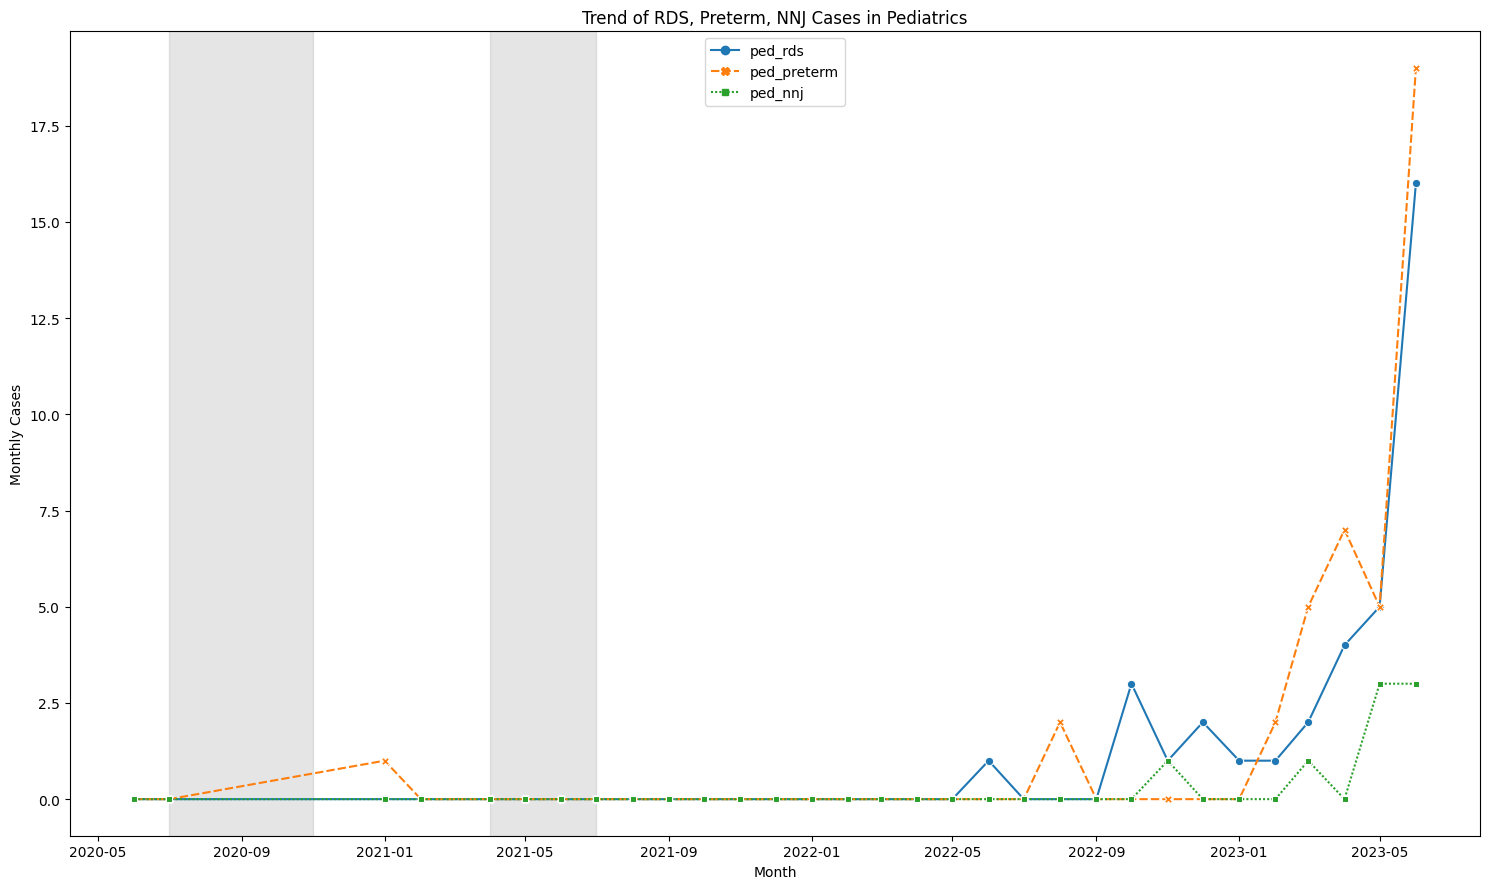

In [5]:
# Create the subplots for the new metrics
fig1, ax1 = plt.subplots(figsize=(15, 9))
fig2, ax2 = plt.subplots(figsize=(15, 9))

# Filter data for plotting
df_adult_metrics = df[(df['age_group'] == 'adult') & df[['sepsis', 'acs', 'covid']].notna().any(axis=1)]
df_pediatric_metrics = df[(df['age_group'] == 'pediatric') & df[['ped_rds', 'ped_preterm', 'ped_nnj']].notna().any(axis=1)]

import seaborn as sns
from matplotlib.dates import DateFormatter

def plot_adult_metrics(ax, data, title):
    # Group data by month
    monthly_metrics = data.groupby('month')[['sepsis', 'acs', 'covid']].sum()
    
    # Plotting covid on the left axis with blue color and 'o' markers
    sns.lineplot(data=monthly_metrics[['covid']], ax=ax, markers=True, label='covid', marker='o', color='blue')
    
    # Create a secondary Y-axis for sepsis and acs
    ax2 = ax.twinx()
    
    # Plot sepsis with dashed line, 'x' markers, and green color
    sns.lineplot(data=monthly_metrics[['sepsis']], ax=ax2, markers=True, linestyle='--', marker='x', color='green', label='sepsis')
    
    # Plot acs with dashed line, no markers, and red color
    sns.lineplot(data=monthly_metrics[['acs']], ax=ax2, linestyle='--', color='red', label='acs')  
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Monthly Cases (COVID)')
    ax2.set_ylabel('Monthly Cases (Sepsis, ACS)')
    ax.set_title(title)
    
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    
    add_covid_shades(ax)  # I'm assuming you've defined this function elsewhere



# Function to plot the pediatric metrics
def plot_pediatric_metrics(ax, data, title):
    # Group data by month
    monthly_metrics = data.groupby('month')[['ped_rds', 'ped_preterm', 'ped_nnj']].sum()
    
    # Plotting
    sns.lineplot(data=monthly_metrics, ax=ax, markers=True)
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Monthly Cases')
    ax.set_title(title)
    
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    
    add_covid_shades(ax)

# Plotting
plot_adult_metrics(ax1, df_adult_metrics, 'Trend of Sepsis, ACS, COVID19 Cases in Adults')
plot_pediatric_metrics(ax2, df_pediatric_metrics, 'Trend of RDS, Preterm, NNJ Cases in Pediatrics')

# Save the new separate plots
plot_file_path_adult_metrics = 'data/covid/adult_metrics_with_covid_waves.png'
plot_file_path_pediatric_metrics = 'data/covid/pediatric_metrics_with_covid_waves.png'

fig1.savefig(plot_file_path_adult_metrics)
fig2.savefig(plot_file_path_pediatric_metrics)

plt.tight_layout()
plt.show()

In [10]:
# Initialize an empty DataFrame to store the aggregated data
aggregate_df = pd.DataFrame()

# Filter data for Adults and Pediatric
adult_data = df[df['age_group'] == 'adult']
ped_data = df[df['age_group'] == 'pediatric']

# Aggregate data for Adults
aggregate_df.loc['Total Admissions', 'Adults'] = adult_data.shape[0]
aggregate_df.loc['Median Apache Score', 'Adults'] = adult_data['apache_score'].median()
aggregate_df.loc['Deaths', 'Adults'] = adult_data[adult_data['discharge_disposition'] == 'Death'].shape[0]
aggregate_df.loc['Discharges', 'Adults'] = adult_data[adult_data['discharge_disposition'] == 'Discharge'].shape[0]
aggregate_df.loc['Transfer Outs', 'Adults'] = adult_data[adult_data['discharge_disposition'] == 'Transfer out'].shape[0]
aggregate_df.loc['Sepsis Cases', 'Adults'] = adult_data['sepsis'].sum()
aggregate_df.loc['Covid Cases', 'Adults'] = adult_data['covid'].sum()

# Aggregate data for Pediatric
aggregate_df.loc['Total Admissions', 'Pediatric'] = ped_data.shape[0]
aggregate_df.loc['Median Apache Score', 'Pediatric'] = ped_data['apache_score'].median()
aggregate_df.loc['Deaths', 'Pediatric'] = ped_data[ped_data['discharge_disposition'] == 'Death'].shape[0]
aggregate_df.loc['Discharges', 'Pediatric'] = ped_data[ped_data['discharge_disposition'] == 'Discharge'].shape[0]
aggregate_df.loc['Transfer Outs', 'Pediatric'] = ped_data[ped_data['discharge_disposition'] == 'Transfer'].shape[0]
aggregate_df.loc['Sepsis Cases', 'Pediatric'] = ped_data['sepsis'].sum()
aggregate_df.loc['Covid Cases', 'Pediatric'] = ped_data['covid'].sum()
aggregate_df.loc['RDS Cases', 'Pediatric'] = ped_data['ped_rds'].sum()
aggregate_df.loc['Preterm Cases', 'Pediatric'] = ped_data['ped_preterm'].sum()
aggregate_df.loc['NNJ Cases', 'Pediatric'] = ped_data['ped_nnj'].sum()

# Show the aggregated table
aggregate_df.fillna(0, inplace=True)
aggregate_df.to_csv('data/covid/baseline_table.csv')

In [8]:
df.discharge_disposition.value_counts()

discharge_disposition
Discharge       43632
Transfer out     6984
Death            5193
Name: count, dtype: int64